# Geo Query Dataset Analysis

In [3]:
import os
import sys

import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

import utils

%matplotlib inline
%load_ext autoreload
%autoreload 2


CSV_PATH = '../../data/unique_counts_semi.csv'

# load data
initial_df = utils.load_queries(CSV_PATH)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Do some cleanup

In [2]:
# filter out queries with length less than 2 characters long                                                                                                          
start_num = len(initial_df)
df = utils.clean_queries(initial_df)

print("{} distinct queries after stripping {} queries of length 1".format(len(df), start_num-len(df)))
print("Yielding a total of {} query occurrences.".format(df['countqstring'].sum()))


39135 distinct queries after stripping 38 queries of length 1
Yielding a total of 84011 query occurrences.


## Query Frequency Analysis

Let's take a look

In [3]:
df.head(10)

,querystring,countqstring
1,Flatshare,1381
2,Jobs,981
3,facebook,607
4,hotmail,415
5,Real Estate,409
6,google,377
7,Hospitality,357
8,Property for Rent,266
9,australia,255
10,gmail,252


The frequency of queries drops off pretty quickly, suggesting a long tail of low frequency queries. Let's get a sense of this by looking at the cumulative coverage of queries with frequencies between 1 and 10.

While we're at it, we can plot the cumulative coverage up until a frequency of 200 (in ascending order of frequency).

Freq   Cumulative Coverage
 1     29.71%
 2     48.20%
 3     58.36%
 4     64.60%
 5     68.29%
 6     71.33%
 7     73.12%
 8     75.03%
 9     76.36%
10     77.66%


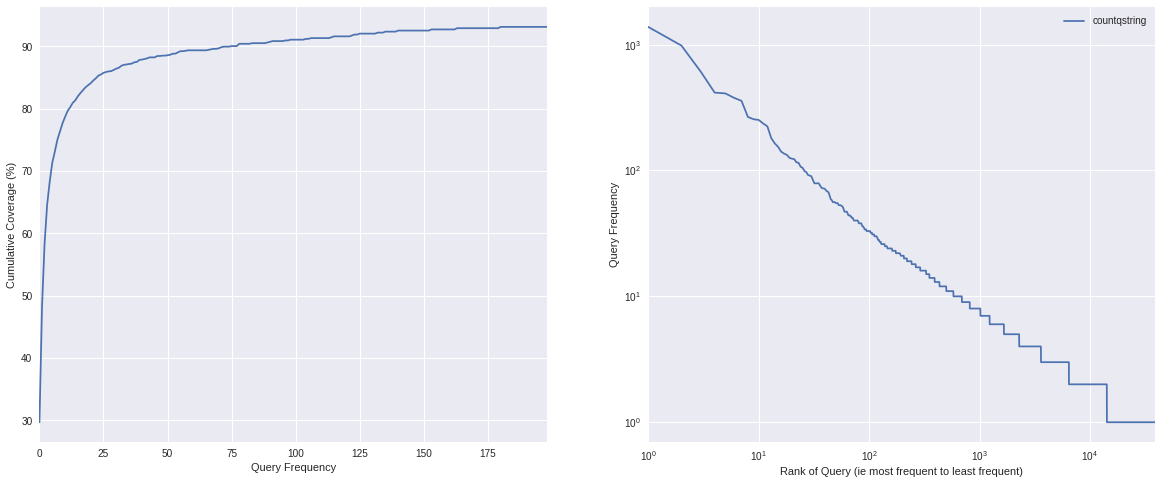

In [4]:
total = df['countqstring'].sum()
fig, ax = plt.subplots(ncols=2, figsize=(20, 8))

cum_coverage = pd.Series(range(1,200)).apply(lambda n: df[df['countqstring'] <= n]['countqstring'].sum())/total
cum_coverage = cum_coverage*100
cum_coverage = cum_coverage.round(2)

# plot the cumulative coverage
cum_coverage.plot(ax=ax[0])
ax[0].set_xlabel('Query Frequency')
ax[0].set_ylabel('Cumulative Coverage (%)')

# see if it looks Zipfian. ie plot a log-log graph of query frequency against query rank 
df.plot(ax=ax[1], y='countqstring', use_index=True, logx=True, logy=True)
ax[1].set_xlabel('Rank of Query (ie most frequent to least frequent)')
ax[1].set_ylabel('Query Frequency');

print("Freq   Cumulative Coverage")
for i, val in enumerate(cum_coverage[:10].get_values()):
    print("{:>2}     {:0<5}%".format(i+1, val))

ie queries with a frequency of 1 account for about 30% of queries, queries with frequency of 2 or less account for 48%, 3 or less account for 58%, etc. 

Looking at the graph it seems like coverate rates drops off exponentially. Plotting a log-log graph of the query frequencies (y-axis) against the descending rank of the query frequency (x-axis) shows a linear-ish trend, suggesting that it does indeed look like some kind of inverse power function situation.

## Annotator Results for Pilot Annotation Round

The pilot annotation round consisted of 50 queries sampled randomly from the total 84011 query instances. Below is a summary of the annotator's results.

### Annotation Codes Map
Q2.

```
'YY' = Yes -- with place name
'YN' = Yes -- without place name
'NY' = No (but still a place)
'NN' = Not applicable (ie not explicit location and not a place)
```

Q3.
```
'IAD' = INFORMATIONAL_ADVICE
'IDC' = INFORMATIONAL_DIRECTED_CLOSED
'IDO' = INFORMATIONAL_DIRECTED_OPEN
'ILI' = INFORMATIONAL_LIST
'ILO' = INFORMATIONAL_LOCATE
'IUN' = INFORMATIONAL_UNDIRECTED
'NAV' = NAVIGATIONAL
'RDE' = RESOURCE_ENTERTAINMENT
'RDO' = RESOURCE_DOWNLOAD
'RIN' = RESOURCE_INTERACT
'ROB' = RESOURCE_OBTAIN
```

In [5]:
print(utils.get_user_results('annotator1'))
print('\n')
print(utils.get_user_results('annotator2'))
print('\n')
print(utils.get_user_results('martin'))

*** Annotator: annotator1 ***

1 Skipped Queries:

    "has it been f"
    --- "Appear to be incomplete; fragment lacks explicit reference to anything"

49 Annotations:

1. Is this query best answered with a pin on a map?
True: 8
False: 41

2. Is a location explicit in the query?
YY: 16
NY: 11
NN: 22

3. What type of query is this?
IAD: 1
IDC: 5
ILI: 4
ILO: 8
IUN: 22
NAV: 8
RDE: 1


*** Annotator: annotator2 ***

2 Skipped Queries:

    "has it been f"
    --- "Appears to be an incomplete question"
    "http:/www.eatability.com.au/au/sydney/chat-thai-sydney/"
    --- "Looks like they entered a url into the search bar. Cannot work out what it's about."

48 Annotations:

1. Is this query best answered with a pin on a map?
True: 11
False: 37

2. Is a location explicit in the query?
YY: 14
YN: 1
NY: 19
NN: 14

3. What type of query is this?
IAD: 1
IDC: 4
IDO: 2
ILI: 7
ILO: 15
IUN: 8
NAV: 9
RIN: 2


*** Annotator: martin ***

1 Skipped Queries:

    "has it been f"
    --- "Incomplete query

### Comments

* It looks like Martin leant substantially more towards annotating queries as being geographical, ie is_geo = True for Q1, compared to both annotators.
* for Q3, Annotator 1 was biased slightly towards INFORMATIONAL_UNDIRECTED, whereas Annotator 2 was biased towards INFORMATIONAL_LOCATE. Martin, on the other hand, favoured INFORMATIONAL_UNDIRECTED, INFORMATIONAL_LOCATE, and NAVIGATIONAL, compared to the remaining categories.   
* what should we do about URLs? Annotator 2 skipped the one URL. Martin and Annotator 1 labelled it as Web Navigational but disagreed regarding location explicit. Martin said 'YN', Annotator 1 said 'NN'.


## Inter-annotator Agreement Scores for Pilot Annotation

The following results present inter-annotater agreement for the pilot round using Fleiss' kappa.

Super handwavy concensus guide to interpreting kappa scores for annotation exercies in computation linguistics (Artstein and Poesio 2008:576):
 * kappa > 0.8 = good reliabiility
 * 0.67 < kappa < 0.8 = tentative conclusions may be drawn regarding the reliability of the data

In [6]:
user_pairs = [
    ['annotator1', 'annotator2'],
    ['martin', 'annotator1'],
    ['martin', 'annotator2'],
]

results = utils.do_iaa_pairs(user_pairs)
utils.print_iaa_pairs(results, user_pairs)

    annotator1, annotator2   martin, annotator1   martin, annotator2
Q1: 0.541                    0.321                    0.400                    
Q2: 0.659                    0.461                    0.505                    
Q3: 0.318                    0.264                    0.303                    


These scores are not particularly high. We're struggling to get into even 'tentative' reliability land. We're probably going to need to do some disagreement analysis to work out what's going on.

We can, however, look at agreement for Q1 and Q2 using coarser level of agreement. For Q2, this is whether annotators agreed that a location was explicit in the query (but ignoring whether the query included a place name).

For Q3, this is whether they agreed that the query was navigational, informational, or pertaining to a resource.

In [7]:
results = utils.do_iaa_pairs(user_pairs, questions=(2,3), level='coarse')
utils.print_iaa_pairs(results, user_pairs)

    annotator1, annotator2   martin, annotator1   martin, annotator2
Q2: 0.857                    0.861                    0.719                    
Q3: 0.619                    0.661                    0.488                    


Agreement has improved, especially for Q2. Q3, however, is still a bit on the low side. 

## Disagreements 

In [8]:
for question in (1,2,3):
    print(utils.show_agreement(question, ['annotator1', 'annotator2', 'martin']))
    print('\n')

Question 1:
Number all agree: 31
Number with some disagreement: 17

annotator1  annotator2  martin      
0           0           1           Movies in Sydney George st cinemas
0           0           1           Double room  best for couple or two girls or partner. student accommodation
0           0           1           sale women
0           0           1           Flatshare
0           1           0           preise im sefton playhouse
0           1           1           ogilvy
0           0           1           Other Jobs
0           0           1           skechers
0           0           1           Hospitality
1           0           1           gilly hicks sydney australia
0           0           1           Jobs
0           0           1           nike free 5.0
1           0           1           negative-ions sydney
0           1           1           gucci
0           0           1           Keyboards
0           1           1           sculpture sydney
0           1      